# Statistical models in R
This notebook is covering:
1. Test predict method for TVECM

In [117]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go

In [118]:
# rpy2 is a Python package that allows you to run R code from Python
%pip install rpy2

Note: you may need to restart the kernel to use updated packages.


In [119]:
# Load the rpy2 extension to use R in Jupyter
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


The magic function `%%R` is used for running R code in Jupyter

In [120]:
%%R
# Install required packages
if (require("dplyr") == FALSE) {
  install.packages("dplyr")
  library(dplyr)
}
if (require("zoo") == FALSE) {
  install.packages("zoo")
  library(zoo)
}
if (require("psych") == FALSE) {
  install.packages("psych")
  library(psych)
}
if (require("TSA") == FALSE) {
  install.packages("TSA")
  library(TSA)
}
if (require("forecast") == FALSE) {
  install.packages("forecast")
  library(forecast)
}
if (require("Metrics") == FALSE) {
  install.packages("Metrics")
  library(Metrics)
}
if (require("ggplot2") == FALSE) {
  install.packages("ggplot2")
  library(ggplot2)
}
if (require("vars") == FALSE) {
  install.packages("vars")
  library(vars)
}
if (require("svars") == FALSE) {
  install.packages("svars")
  library(svars)
}
if (require("tsDyn") == FALSE) {
  install.packages("tsDyn")
  library(tsDyn)
}
if (require("devtools") == FALSE) {
  install.packages("devtools")
  library(devtools)
}


In [191]:
%%R
# Load data
hub_prices <- list(
  nbp = read.csv("../../data/interpolated/nbp_close_interpolated.csv"),
  peg = read.csv("../../data/interpolated/peg_close_interpolated.csv"),
  the = read.csv("../../data/interpolated/the_close_interpolated.csv"),
  ttf = read.csv("../../data/interpolated/ttf_close_interpolated.csv"),
  ztp = read.csv("../../data/interpolated/ztp_close_interpolated.csv")
)

In [444]:
%%R

hub1_name <- "ttf"
hub2_name <- "the"

hub1 <- hub_prices[[hub1_name]]
hub2 <- hub_prices[[hub2_name]]

hubs <- data.frame(hub1 = hub1$CLOSE, hub2 = hub2$CLOSE)

In [445]:
%%R
horizon <- 250
window_size <- 5
nthresh <- 2

train_size <- nrow(hubs) - horizon - window_size
hub_train <- hubs[1:train_size+1, ]


161 (0.8%) points of the grid lead to regimes with percentage of observations < trim and were not computed
Best threshold from first search 4.376764 
Best cointegrating value 0.9606131 
There were  2  thresholds values which minimize the SSR in the conditional step, the first one was taken
Second best (conditionnal on the first one) 4.376764 2.773803 	 SSR 84036.51 
There were  8  thresholds values which minimize the SSR in the iterative step, the first one was taken
Second step best thresholds 2.773803 4.376764 			 SSR 84036.51 
351 (1.8%) points of the grid lead to regimes with percentage of observations < trim and were not computed
Best threshold from first search 4.197 
Best cointegrating value 0.9621694 
There were  2  thresholds values which minimize the SSR in the conditional step, the first one was taken
Second best (conditionnal on the first one) 4.197 2.774 	 SSR 78989.6 
There were  4  thresholds values which minimize the SSR in the iterative step, the first one was taken
Se

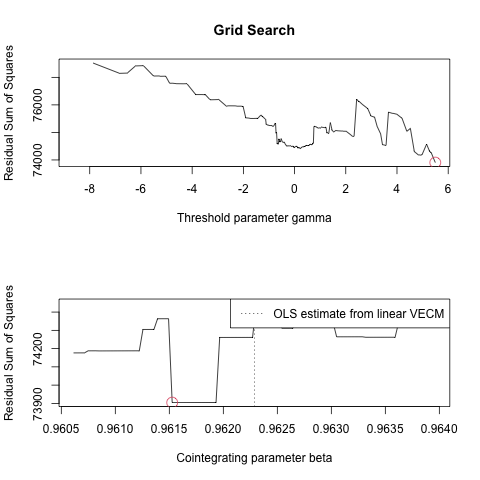

In [446]:
%%R
aics <- c()
bics <- c()
max_lag <- 8
for (p in 1:max_lag) {
  tvecm <- TVECM(hub_train, include = "const", nthresh=nthresh,lag=p, ngridBeta=100, ngridTh=200, plot=TRUE,trim=0.05, common="All")
  aics <- c(aics, AIC(tvecm))
  bics <- c(bics, BIC(tvecm))
}

[1] 8


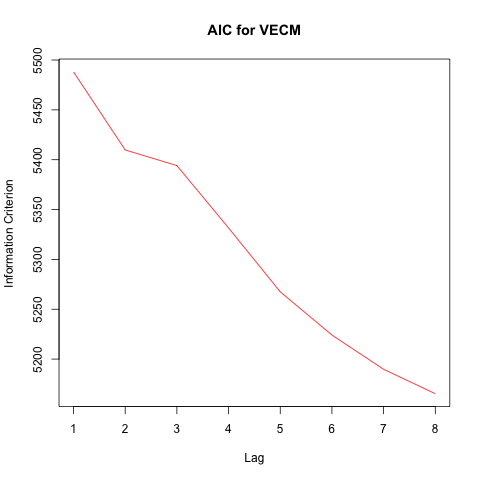

In [447]:
%%R
aic_lags <- which.min(aics)
print(aic_lags)
plot(1:max_lag, aics, type = "l", col = "red", xlab = "Lag", ylab = "Information Criterion", main = "AIC for VECM")

[1] 2


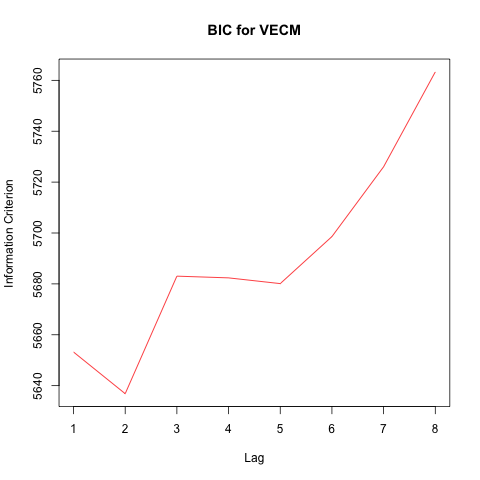

In [448]:
%%R
bic_lags <- which.min(bics)
print(bic_lags)
plot(1:max_lag, bics, type = "l", col = "red", xlab = "Lag", ylab = "Information Criterion", main = "BIC for VECM")

In [449]:
%%R
# Based on the predict.TVAR function from the tsDyn package
predict.TVECM <- function(object, newdata, n.ahead=5, 
                        newdataTrendStart, ...){
  
  ## extract parameters, coefs
  lag <- object$lag
  k <- object$k
  include <- object$include
  B <- object$coeffmat  
  Thresh <- getTh(object)
  nthresh <- object$model.specific$nthresh
  beta <- object$model.specific$beta

  
  ## setup starting values (data in y), innovations (0)
  original.data <- object$model[,1:k, drop=FALSE]
  starting <-   tsDyn:::myTail(original.data,lag)
  innov <- matrix(0, nrow=n.ahead, ncol=k)  

  
  
  if(!missing(newdata)) {
    if(!inherits(newdata, c("data.frame", "matrix","zoo", "ts"))) stop("Arg 'newdata' should be of class data.frame, matrix, zoo or ts")
    if(nrow(newdata)!=lag+1) stop(paste0("Please provide newdata with nrow=lag=", lag+1))
    starting <-  as.matrix(newdata)
  }
  
  ## trend DOES NOT WORK YET
  if(missing(newdataTrendStart)){
    if(include%in%c("trend", "both")){
      trendStart <- object$t+1
    }  else {
      trendStart <- 0
    }
  } else {
    trendStart <- newdataTrendStart
  }
  
  
  res <- tsDyn:::TVECM.gen(B=B, beta=beta, n=n.ahead, lag=lag, 
                      include = include, 
                      nthresh= nthresh,
                      Thresh = Thresh, 
                      starting=starting, innov=innov)
  
  ## format results
  colnames(res) <- colnames(original.data)
  end_rows <- nrow(original.data) + n.ahead
  if(hasArg("returnStarting") && isTRUE(list(...)["returnStarting"])) {
    start_rows <- nrow(original.data)+1 - lag
  } else {
    start_rows <- nrow(original.data)+1
  }
  rownames(res) <- start_rows : end_rows
  
  return(res)
}

In [450]:
%%R
vecm_predictions <- function(hubs,  window_size = 5, horizon = 250) {
  
  # Initialize empty data frames for storing predictions and actual values
  predictions <- data.frame(matrix(ncol = ncol(hubs), nrow = 0))
  actuals <- data.frame(matrix(ncol = ncol(hubs), nrow = 0))
  
  colnames(predictions) <- colnames(hubs)
  colnames(actuals) <- colnames(hubs)

  train_size <- nrow(hubs) - horizon - window_size
  hub_train <- hubs[1:train_size+1, ]

  n_lags <- bic_lags

  tvec <- TVECM(hub_train, include = "const", nthresh=nthresh,lag=n_lags, ngridBeta=100, ngridTh=200, plot=TRUE,trim=0.05, common="All")

  
  for (i in 1:horizon) {

    start <- train_size - n_lags + i
    end <- train_size + i

    pred_data <- hubs[start:end, ]
    # Fit the VECM model

    hub_forecast <- predict.TVECM(tvec, newdata=pred_data, n.ahead=window_size)
    
    hub_prediction <- hub_forecast[window_size, , drop = FALSE]
    
    hub_actual <- hubs[end + window_size, ]
    
    predictions <- rbind(predictions, hub_prediction)
    actuals <- rbind(actuals, hub_actual)
  }
  
  # Return both data frames as a list
  return(list(predictions = predictions, actuals = actuals))
}
  

351 (1.8%) points of the grid lead to regimes with percentage of observations < trim and were not computed
Best threshold from first search 4.197 
Best cointegrating value 0.9621694 
There were  2  thresholds values which minimize the SSR in the conditional step, the first one was taken
Second best (conditionnal on the first one) 4.197 2.774 	 SSR 78989.6 
There were  4  thresholds values which minimize the SSR in the iterative step, the first one was taken
Second step best thresholds 2.774 4.197 			 SSR 78989.6 
[1] "Pair: ttf | the"
[1] "ttf: Mean Absolute Error: 2.17507599146821"
[1] "ttf: Root Mean Squared Error: 3.0303761202484"
[1] "the: Mean Absolute Error: 2.18528461362617"
[1] "the: Root Mean Squared Error: 2.92175903759817"


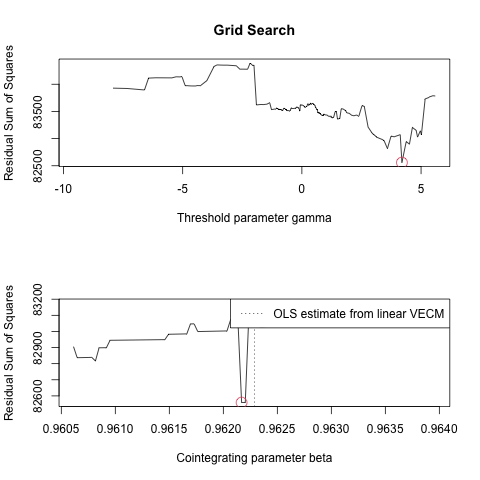

In [451]:
%%R
window_size <- 5
horizon <- 250

vecm_output <- vecm_predictions(hubs, window_size = window_size, horizon = horizon)
hub1_predictions <- vecm_output$predictions$hub1
hub1_actuals <- vecm_output$actuals$hub1
hub2_predictions <- vecm_output$predictions$hub2
hub2_actuals <- vecm_output$actuals$hub2

hub1_mae <- mae(hub1_actuals, hub1_predictions)
hub2_mae <- mae(hub2_actuals, hub2_predictions)

hub1_rmse <- rmse(hub1_actuals, hub1_predictions)
hub2_rmse <- rmse(hub2_actuals, hub2_predictions)

print(paste0("Pair: ", hub1_name, " | ", hub2_name))
print(paste0(hub1_name,": Mean Absolute Error: ", hub1_mae))
print(paste0(hub1_name,": Root Mean Squared Error: ", hub1_rmse))

print(paste0(hub2_name,": Mean Absolute Error: ", hub2_mae))
print(paste0(hub2_name,": Root Mean Squared Error: ", hub2_rmse))

In [452]:
%%R
predictions <- vecm_output$predictions
actuals <- vecm_output$actuals

colnames(predictions) <- c(hub1_name, hub2_name)
colnames(actuals) <- c(hub1_name, hub2_name)

prediction_dates = tail(hub1$Date, horizon)
predictions <- cbind(data.frame(Date = prediction_dates), predictions)
actuals <- cbind(data.frame(Date = prediction_dates), actuals)

In [453]:
%%R
write.csv(predictions, paste0("../../predictions/",hub1_name,"_", hub2_name, "_h", horizon, "_w", window_size, "_tvecm_", "t", nthresh, "_predictions.csv"), row.names = FALSE)